# dIdV Analysis, Energy Resolution, and Noise Model for Single Channel

**In the notebook, we demonstrate how to analyze <i>beginning of run</i>  didv data of a continuous data taking and calculate energy resolution by doing the following:**

  1. <font color="blue"><b>Analyze dIdV data:</b></font>
      * Process didv data (select good traces using autocuts, calculate offset/mean)
      * Fit dIdV data with both 2 and 3 poles
      * Calculate small signal parameters with true I0, R0 (re-calculated using results from IV sweep)<br><br>
  2. <font color="blue"><b>Calculate PSD </b></font>using random triggers selected from continuous data<br><br> 
  3. <font color="blue"><b>Create template</b></font>: functional form defined as the sum of 3 two-poles functions <br><br>
  4. <font color="blue"><b>Calculate dPdI</b></font> for the frequencies of the PSD<br><br>
  5. <font color="blue"><b>Calculate energy resolution</b></font>

In [2]:
import qetpy as qp
import numpy as np
import pandas as pd
from pprint import pprint
import matplotlib.pyplot as plt
import pickle

# detprocess
from detprocess import Noise, DIDVAnalysis, FilterData, Template, NoiseModel

### Channels name and continuous data path, and dIdV <i>series</i> name


In [3]:
channel_name = 'Melange1pc1ch'

# Continuous data path and series with both channels
continuous_data_path = '/sdata1/runs/run28/raw/continuous_I2_D20230630_T193129'
continuous_data_series = 'I2_D20230630_T193742'
didv_borr_series = 'I2_D20230630_T193200'

## Analyze dIdV data

### Instantiate DIDVAnalysis and process data

In [4]:
# instantiate didvanalysis
# Let's auto save to hdf5 file 
didvanalysis = DIDVAnalysis(verbose=True, auto_save_hdf5=True)

# process raw data
# if already process use didvanalysis.set_processed_data(channel, didv_data=dictionary or pandas series)
didvanalysis.process_raw_data(channel_name, continuous_data_path, series=didv_borr_series)

INFO: Results will be automatically saved in didv_analysis_D20240215_T105148.hdf5
INFO: Getting raw data and processing channel Melange1pc1ch


### Set IV sweep results 

Let's get the result from the IV sweep (see  jupyter notebook "ivsweep_analysis_demo.ipynb"), adding some parameters (I0,R0,...) from the bias point as well for comparison

In [17]:
# load IV Sweep results (nboth Melange1pc1ch and Melange4pc1ch stored in same file)
ivsweep_file = '/sdata1/runs/run28/filterdata/iv_didv_I2_D20230615_T231959/ivsweep_analysis_D20240214_T165303.hdf5'
didvanalysis.set_ivsweep_results_from_file(channel_name, file_name=ivsweep_file, include_bias_parameters=True)

INFO: Loading filter data from file /sdata1/runs/run28/filterdata/iv_didv_I2_D20230615_T231959/ivsweep_analysis_D20240214_T165303.hdf5


In [18]:
print(f'{channel_name} IV Sweep Results:\n')
ivsweep_results = didvanalysis.get_ivsweep_results(channel_name)
pprint(ivsweep_results)

Melange1pc1ch IV Sweep Results:

{'close_loop_norm': 625000.0,
 'didv_fit_L': 5.614209195711356e-07,
 'didv_fit_L_err': 1.0225377208760026e-08,
 'didv_fit_beta': 0.1503835455012701,
 'didv_fit_beta_err': 0.02485057859426574,
 'didv_fit_chi2': 0.16442438442595048,
 'didv_fit_gratio': 0.7610577419700227,
 'didv_fit_gratio_err': 0.025153659673940426,
 'didv_fit_l': 2.7548089208669326,
 'didv_fit_l_err': 0.17661726465265778,
 'didv_fit_tau+': 4.488156597017e-06,
 'didv_fit_tau-': 8.760460756828013e-05,
 'didv_fit_tau0': 0.00032108994533272507,
 'didv_fit_tau0_err': 2.4205997068411738e-05,
 'didv_fit_tau3': 0.0003989993316093405,
 'group_name_sweep': 'iv_didv_I2_D20230615_T231959',
 'i0': 5.515936532052498e-07,
 'i0_err': 9.824970272549315e-11,
 'i0_err_infinite_lgain': 1.2889355895911574e-08,
 'i0_infinite_lgain': 4.644414990781708e-07,
 'i0_off': -8.103776886022854e-07,
 'i0_off_err': 2.374095508725114e-11,
 'i0_variable_offset': -5.763126015663147e-06,
 'ibias': 1.2966352281429343e-05,
 

### dIdV 2 and 3 poles fit


Melange1pc1ch dIdV Fit Result:
Fit chi2/Ndof = 0.169

Fit time constants, NOT dIdV Poles: 
Tau1: 9.93e-05 s
Tau2: 5.19e-06 s
Tau3: 0.0002936 s
 

True dIdV Poles: 
Tau_plus: 5.84e-06 s
Tau_minus: 8.16e-05 s
Tau_third: 0.0003882 s

Melange1pc1ch dIdV Fit Plots:


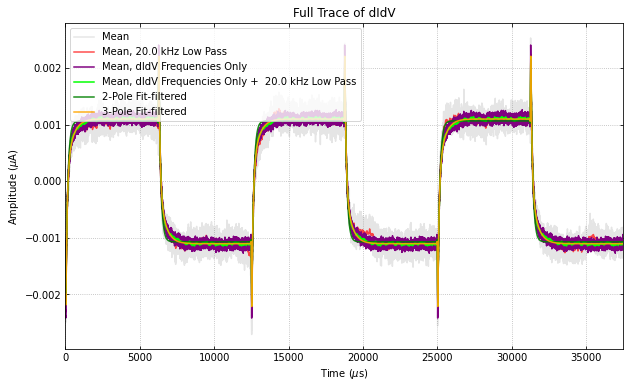

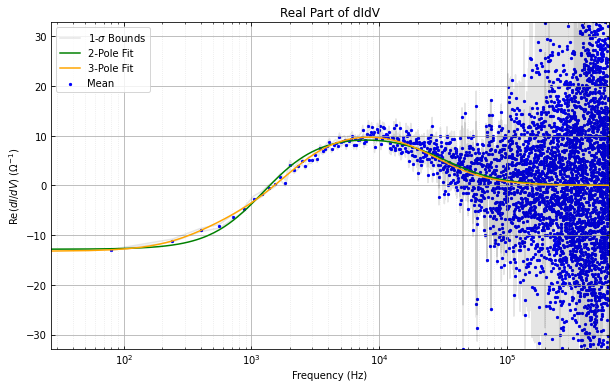

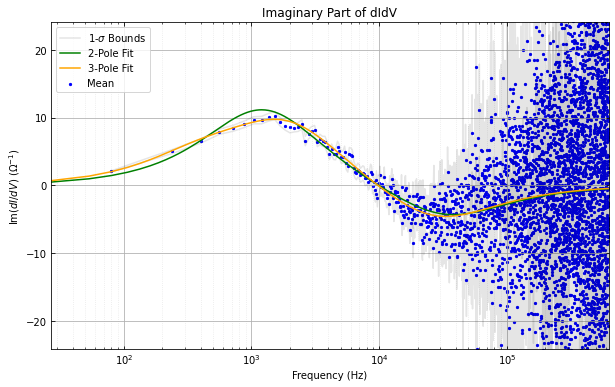

INFO: Saving filter/TES data to file /sdata1/runs/run28/filterdata/continuous_I2_D20230630_T193129/didv_analysis_D20240215_T105148.hdf5! (overwrite=True)


In [19]:
didvanalysis.dofit([2,3], lgc_plot=True )

### Calculate small signal parameters, using </i>true</i>  I0 and  R0

In [20]:
didvanalysis.calc_smallsignal_params(calc_true_current=True)

INFO: Calculating small signal parameters uncertainties for channel Melange1pc1ch
INFO: Calculating true current!
 
----------------------------------------------------------------
ALERT: Variable output voltage offset has changed since the IV sweep.
Thus, it needs to be taken into account when calculating true I0!
IV sweep variable offset [muAmps]: -5.763126015663147
This dIdV dataset variable offset [muAmps]: -7.716727852821351
RESULTS MAY NOT BE ACCURATE IF GAIN/OFFSET NON LINEARITIES!
----------------------------------------------------------------
 
INFO: Saving filter/TES data to file /sdata1/runs/run28/filterdata/continuous_I2_D20230630_T193129/didv_analysis_D20240215_T105148.hdf5! (overwrite=True)


### Let's compare <i>true</i> bias parameters I0, R0, P0  with parameters from IV sweep  

We will compare the calculate bias parameters with IV Sweep. Also we can calculated bias parameters using 
dIdV fit only with infinite loop gain approximation (independent of offsert)




In [21]:
# let's first calculate bias parameters with infinite loop gain calculation
didvanalysis.calc_bias_params_infinite_loop_gain()

INFO: Calculating bias parameters with infinite loop gain approximation for channel Melange1pc1ch
INFO: Saving filter/TES data to file /sdata1/runs/run28/filterdata/continuous_I2_D20230630_T193129/didv_analysis_D20240215_T105148.hdf5! (overwrite=True)


In [22]:
print(f'{channel_name} Comparison between BOR dIdV and IV Sweep ')
df = didvanalysis.compare_with_ivsweep(channel_name)
df

Melange1pc1ch Comparison between BOR dIdV and IV Sweep 


,dIdV,IV Sweep
R0 [mOhms],54.5 +/- 0.004551,109 +/- 2.252
R0 Inf loop gain [mOhms],84.5 +/- 0.4243,131 +/- 3.878
I0 [muAmps],1 +/- 8.297e-05,0.552 +/- 9.825e-05
I0 Inf loop gain [muAmps],0.681 +/- 0.003093,0.464 +/- 0.01289
P0 [fWatts],54.8 +/- 0.004573,33 +/- 0.6852
P0 Inf loop gain [fWatts],39.2 +/- 0.1785,28.2 +/- 0.7839
l (loop gain),3.39 +/- 0.1239,2.75 +/- 0.1766
beta,0.852 +/- 0.01699,0.15 +/- 0.02485
gratio,0.453 +/- 0.01844,0.761 +/- 0.02515
L [nH],571 +/- 13.89,561 +/- 10.23


As we can see above the <b>bias power seems to have drastically increase</b> since IV sweep. However, the dIdV data has been taken with different output variable offset, which can be modified from readout electronics. <b>The variable offset is not very linear and thus there is a large error.</b><br>

We will calculate later the energy resolution using both "true" current and current using infinite loop gain approximation.

## Energy Resolution  

Let's calculate energy resolution using 20ms traces for both "true" current and  current with "infinite loop gain approximation"

  1. <b>Calculate PSD (two-sided)</b> using traces randomly selected in continuous data
  2. <b>Calculate Template</b> (same template as for IV sweep)
  3. <b>Calculate dPdI over the frequencies from PSD</b>
  4. <b>Calculate energy resolution</b>

### Noise PSD

#### Select randoms

In [23]:
noise = Noise(verbose=True)
noise.generate_randoms(continuous_data_path, series=continuous_data_series, 
                       nevents=1000, min_separation_msec=100, ncores=1)


INFO: Found total of 4 raw data file(s) from 1 different series number!
INFO: Found total of 4 files from 1 different series number!
INFO node #1: Acquiring randoms for series I2_D20230630_T193742
INFO: Randoms acquisition done!


#### Calculate PSD (two-sided)

INFO: Processing PSD for channel Melange1pc1ch
INFO: 840 events found in raw data for channel(s) Melange1pc1ch
INFO: Number of events after cuts = 234, efficiency = 27.86%


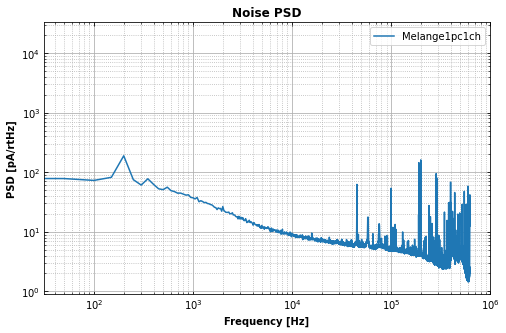

In [24]:
# 20 ms trace length
trace_length_msec = 20
pretrigger_length_msec = 10


# calculate PSD
noise.calc_psd(channel_name,
               nevents=1000,
               trace_length_msec=trace_length_msec, 
               pretrigger_length_msec=pretrigger_length_msec)

# get values
psd, psd_freqs = noise.get_psd(channel_name)
fs = noise.get_sample_rate()

# display
noise.plot_psd(channel_name, fold=True)


### Functional Form Template  (sum of three 2-poles function)

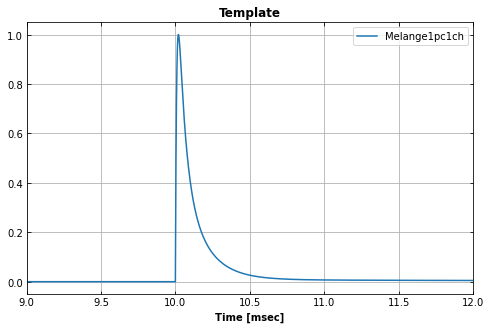

In [25]:
# instantiate template object
template_inst = Template()

# Template Melange 1%1
amplitudes = [1.67e-15, 1.32e-15, 2.39e-17]
fall_times = [44.6e-6, 147.5e-6, 3872.9e-6]
rise_times = [8.79e-6, 8.79e-6, 8.79e-6]

template_inst.create_template_sum_twopoles(channel_name, 
                                           amplitudes, rise_times, fall_times,
                                           sample_rate=fs,
                                           trace_length_msec=trace_length_msec,
                                           pretrigger_length_msec=pretrigger_length_msec) 



# get templates array
template, time_array = template_inst.get_template(channel_name)


# display
template_inst.plot_template(channel_name, xmin=9, xmax=12)


### dPdI and energy resolution calculation with "true" current

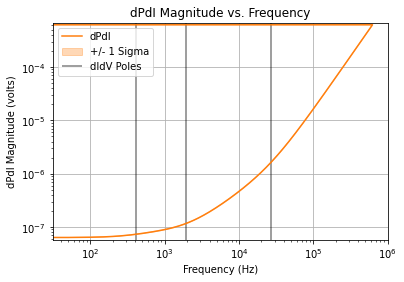

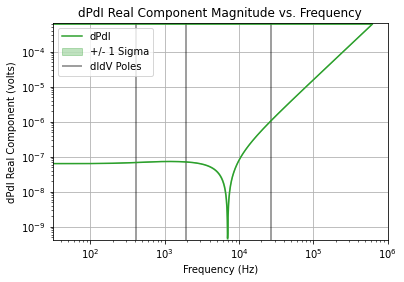

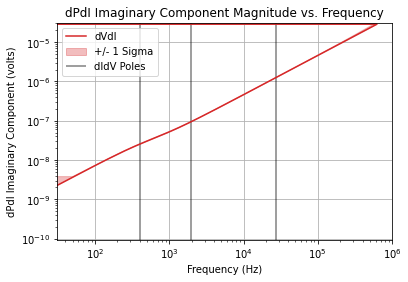

INFO: Saving filter/TES data to file /sdata1/runs/run28/filterdata/continuous_I2_D20230630_T193129/didv_analysis_D20240215_T105148.hdf5! (overwrite=True)


In [26]:
# dPdI over psd frequencies
didvanalysis.calc_dpdi(psd_freqs, list_of_poles=[3], lgc_plot=True)

In [27]:
# let's use same collection efficiency as for the IV sweep
collection_eff = ivsweep_results['resolution_collection_efficiency']
print('Melange 1% collection efficiency = {:.3f}'.format(collection_eff))

Melange 1% collection efficiency = 0.420


In [28]:
resolution = didvanalysis.calc_energy_resolution(channel_name, 
                                                 psd,
                                                 fs=fs, 
                                                 template=template,
                                                 collection_eff=collection_eff,
                                                 lgc_power_template=True)

# display
print('Melange 1% energy resolution = {:.3g} meV'.format(resolution*1000))


Melange 1% energy resolution = 651 meV


## Noise Model Analysis

  The normal noise and SC have been already analyzed during IV sweep analysis and results stored 
  in HDF5 file
  

#### Instantiate NoiseModel

In [29]:
noise_sim = NoiseModel()

#### Set Tbath 

In [30]:
# get data config and check if temperature available
data_config = didvanalysis.get_didv_data(channel_name)['data_config']

temperature_mc = data_config['temperature_mc']
print(f'MC Temperature = {temperature_mc*1e3} mK')

# set TBath
noise_sim.set_tbath(temperature_mc)

MC Temperature = 7.120303809642792 mK


#### Set Tc

In [31]:
noise_sim.set_tc(channel_name, 48e-3)

#### Set Normal and SC  fit results from IV Sweep

In [32]:
squiddc = ivsweep_results['noise_model_fit_squiddc']
squidpole = ivsweep_results['noise_model_fit_squidpole']
squidn = ivsweep_results['noise_model_fit_squidn']
tload = ivsweep_results['noise_model_fit_tload']

noise_sim.set_normal_fit_results(channel_name, squiddc=squiddc, 
                                 squidpole=squidpole, squidn=squidn)

noise_sim.set_sc_fit_results(channel_name, tload=tload)

#### Set PSD

In [33]:
tes_bias = data_config['tes_bias']

noise_sim.set_psd(channel_name, psd, psd_freqs, tes_bias, 'transition')

#### Set dIdV 2-poles fit result

In [34]:
didv_fit = didvanalysis.get_fit_results(channel_name, 2)
noise_sim.set_iv_didv_results_from_dict(channel_name, didv_results=didv_fit)

#### Analysis noise

You can set more precise Gta using function "set_gta(Melange1pc1ch, gta)"!


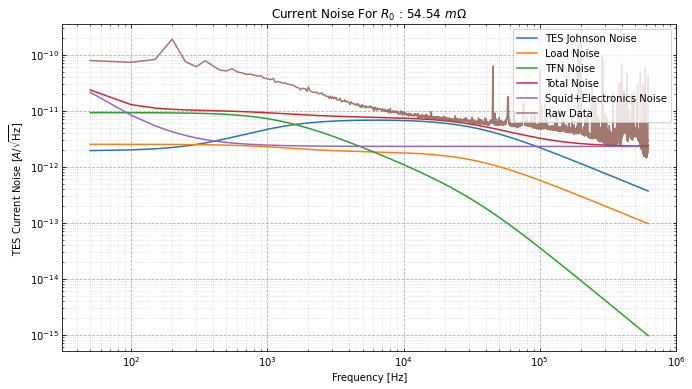

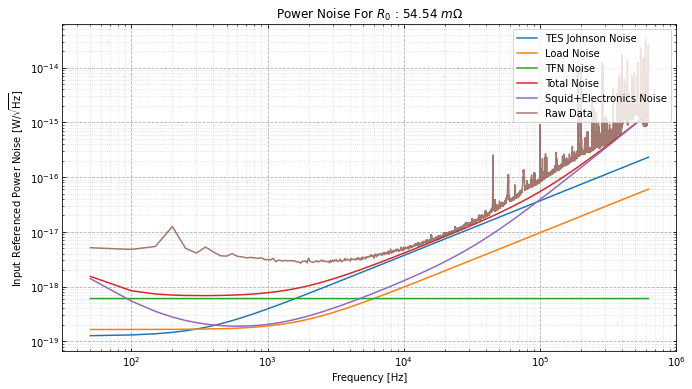

In [35]:
noise_sim.analyze_noise(channels=channel_name, lgc_plot=True)